# Подготовка модели распознавания рукописных букв и цифр

Вам предстоит самостоятельно обучить модель для задачи распознавания рукописных букв и цифр с помощью датасета `emnist`. Результатом должна быть обученная модель, сохранённая в файл `model.pkl`.

Можете воспользоваться предложенным порядком действий и подсказками из этого ноутбука или подойти к решению задачи самостоятельно и написать всё с нуля. То же касается и процесса упаковки модели в сервис для распознавания самостоятельно написанных символов.

В этом ноутбуке комментариями и символами `...` отмечены места для вашего кода.

Перед отправкой решения убедитесь, что все ячейки ноутбука выполняются последовательно без ошибок, если запустить `Kernel -> Restart & Run All`.

Успехов!

### 1. Установите и импортируйте необходимые библиотеки

In [1]:
# Чтобы не мешали предупреждающие сообщения...
import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

# Проверяем, установлен ли emnist
try:
    importlib.import_module('emnist')
    print('emnist уже установлен')
except ImportError:
    print('emnist не установлен, устанавливаю...')
    # Устанавливаем tensorflow
    !pip install emnist


emnist уже установлен


In [3]:
# Проверяем, установлена ли библиотека tensorflow
try:
    importlib.import_module('tensorflow')
    print('TensorFlow уже установлен')
except ImportError:
    print('TensorFlow не установлен, устанавливаю...')
    # Устанавливаем tensorflow
    !pip install tensorflow


TensorFlow уже установлен


In [28]:
import os
import pickle
import emnist
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import itertools
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


### 2. Загрузите датасет и проанализируйте его

Датасет в качестве лейблов (или таргетов) содержит числа от 0 до 46. Каждому числу соответствует ASCII-код некоторого символа. Пары «лейбл — код» хранятся в файле `emnist-balanced-mapping.txt`.
Выведите на экран количество семплов в каждом сплите датасета и размер изображений. Также для каждого лейбла выведите соответствующий ему символ и количество тренировочных семплов, приходящееся на него.
Посмотрите на несколько примеров изображений.

_Подсказка: чтобы получить символ из ASCII-кода, нужно воспользоваться функцией_ `chr()`. _Для вашего удобства можно построить словарь_ (`dict`) _соответствий._

In [5]:
# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()


In [7]:
# Вывод размерности данных
print(f"Размерность train_images: {train_images.shape}")
print(f"Размерность train_labels: {train_labels.shape}")
print(f"Размерность test_images: {test_images.shape}")
print(f"Размерность test_labels: {test_labels.shape}")

Размерность train_images: (60000, 28, 28)
Размерность train_labels: (60000,)
Размерность test_images: (10000, 28, 28)
Размерность test_labels: (10000,)


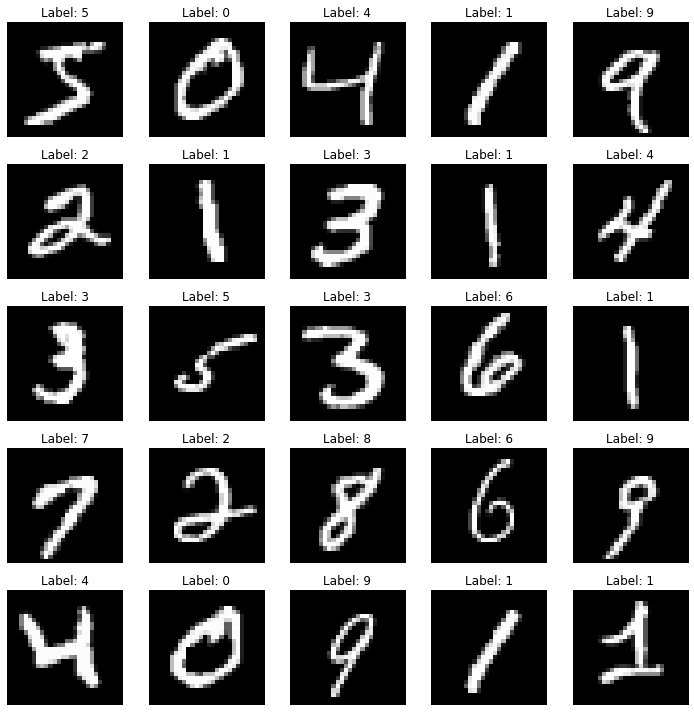

In [8]:
# Отобразим сетку 5x5 изображений из обучающего набора
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f'Label: {train_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### 3. Подготовьте датасет для обучения и валидации

_Подсказка: чтобы вытянуть изображения в вектор, понадобится метод_ `reshape` _из библиотеки_ `numpy`.

In [9]:
# Создание модели Sequential
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),  # Преобразование изображения 28x28 в плоский вектор (784,)
    layers.Dense(128, activation='relu'),  # Полносвязный слой с 128 нейронами и функцией активации ReLU
    layers.Dropout(0.2),                   # Dropout для уменьшения переобучения
    layers.Dense(10)                       # Выходной слой с 10 нейронами (по числу классов)
])

# Компиляция модели
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Вывод структуры модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### 4. Выберите модель, обучите её, протестируйте и сохраните

Выведите на экран точность вашей модели. Выведите и проанализируйте матрицу ошибок. Какие два символа она чаще всего путает? На каком символе модель чаще всего ошибается?

#### 4.1. Cоздадим простую нейронную сеть (Sequential model)

In [10]:
# Обучение модели на данных
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Оценка точности на тестовом наборе данных
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nТочность на тестовом наборе данных: {test_acc}')

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 2.5108 - accuracy: 0.7386 - val_loss: 0.5747 - val_accuracy: 0.8718
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6235 - accuracy: 0.8366 - val_loss: 0.3873 - val_accuracy: 0.9131
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4860 - accuracy: 0.8686 - val_loss: 0.4008 - val_accuracy: 0.9202
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4341 - accuracy: 0.8817 - val_loss: 0.2968 - val_accuracy: 0.9273
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3922 - accuracy: 0.8949 - val_loss: 0.2608 - val_accuracy: 0.9408
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3762 - accuracy: 0.9000 - val_loss: 0.2608 - val_accuracy: 0.9382
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3493 - accuracy: 0.9076 - val_loss: 0.2995 - val_accuracy:

#### Функции анализа работы моделей: `визуализация точности обучения и потерь` и `вывод матрицы ошибок`

In [11]:

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
def evaluate_and_visualize(model, test_images, test_labels, classes):
    """
    Функция для оценки модели, визуализации матрицы ошибок и графиков точности/потерь.
    
    Аргументы:
    model -- обученная модель TensorFlow/Keras
    test_images -- тестовые изображения для оценки
    test_labels -- истинные метки тестовых изображений
    classes -- список классов или меток, которые модель предсказывает
    """
    # Оценка точности на тестовом наборе данных
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f'\nТочность на тестовом наборе данных: {test_acc}')

    # Получаем предсказания модели на тестовом наборе данных
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Строим матрицу ошибок
    cm = confusion_matrix(test_labels, predicted_labels)

    # Выводим матрицу ошибок
    print('\nМатрица ошибок:')
    print(cm)

    # Находим наиболее часто путаемые символы
    most_confused_pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                most_confused_pairs.append((i, j, cm[i, j]))

    most_confused_pairs.sort(key=lambda x: x[2], reverse=True)

    print('\nНаиболее часто путаемые символы:')
    for pair in most_confused_pairs[:5]:  # выводим топ-5
        print(f'Символ {classes[pair[0]]} (настоящий) <-> Символ {classes[pair[1]]} (предсказанный): {pair[2]} случаев')

    # Находим символ с наибольшим количеством ошибок
    most_errors_symbol = np.argmax(np.sum(cm, axis=1))
    print(f'\nСимвол с наибольшим количеством ошибок: {classes[most_errors_symbol]}')

    # Функция для отображения матрицы ошибок
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Матрица ошибок',
                              cmap=plt.cm.Blues):
        """
        Эта функция печатает и строит матрицу ошибок.
        Нормализация можно применить, установив значение `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Нормализованная матрица ошибок")
        else:
            print('Матрица ошибок без нормализации')

        plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('Истинные метки')
        plt.xlabel('Предсказанные метки')
        plt.tight_layout()

        # Выводим матрицу ошибок
        plt.show()

    # Визуализируем нормализованную матрицу ошибок
    plot_confusion_matrix(cm, classes, normalize=True)

    # Визуализируем графики точности и потерь
    plt.figure(figsize=(10, 5))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Точность (обучающий набор)')
    plt.plot(history.history['val_accuracy'], label='Точность (валидационный набор)')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.title('График точности')
    plt.legend()

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Потери (обучающий набор)')
    plt.plot(history.history['val_loss'], label='Потери (валидационный набор)')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('График потерь')
    plt.legend()

    plt.tight_layout()
    plt.show()


313/313 - 0s - loss: 0.3859 - accuracy: 0.9292 - 288ms/epoch - 919us/step

Точность на тестовом наборе данных: 0.9291999936103821
313/313 [==============================] - 0s 830us/step

Матрица ошибок:
[[ 911    1    2    0    1    3   14    1   46    1]
 [   0 1108    2    4    0    3    1    0   17    0]
 [   0    2  951   30    1    2    1   11   32    2]
 [   0    0    5  925    0   36    0    8   21   15]
 [   0    1    3    2  840    0    7    4   22  103]
 [   1    0    1   13    1  827    5    2   32   10]
 [   3    4    0    0    5   28  907    0   10    1]
 [   0    8   11   30    0    0    0  963    3   13]
 [   2    2    2   14    5   23    8    5  908    5]
 [   0    3    0    5    3    8    2    4   32  952]]

Наиболее часто путаемые символы:
Символ 4 (настоящий) <-> Символ 9 (предсказанный): 103 случаев
Символ 0 (настоящий) <-> Символ 8 (предсказанный): 46 случаев
Символ 3 (настоящий) <-> Символ 5 (предсказанный): 36 случаев
Символ 2 (настоящий) <-> Символ 8 (предсказа

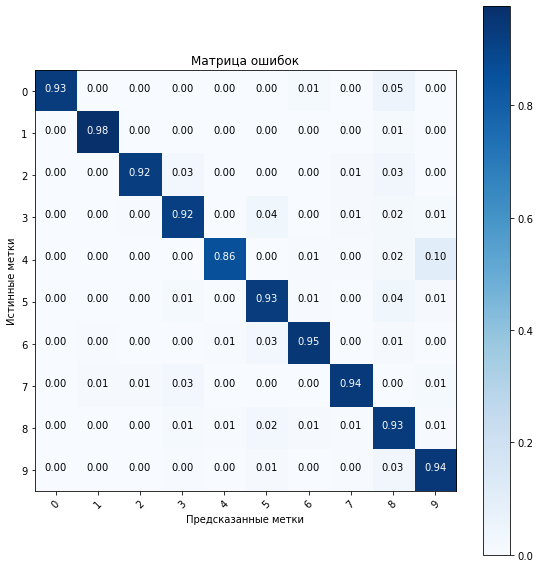

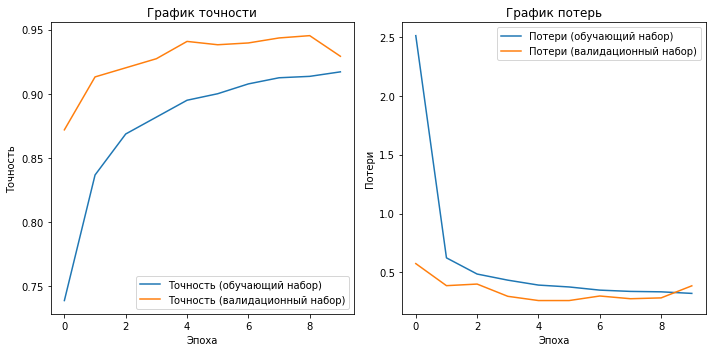

In [12]:
evaluate_and_visualize(model, test_images, test_labels, classes)

#### 4.2. Сверточная нейронная сеть (Convolutional Neural Network, CNN)
CNN обычно хорошо работают для задач обработки изображений, так как они сохраняют пространственные зависимости между пикселями. 

In [13]:
# Нормализация данных (масштабирование значений в диапазон от 0 до 1)
train_images, test_images = train_images / 255.0, test_images / 255.0

# Размеры изображений MNIST
img_rows, img_cols = 28, 28

# Изменение формы данных для подхода CNN (добавление размерности канала)
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# Создание модели CNN
model_CNN = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10)
])

# Компиляция модели
model_CNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Вывод структуры модели
model_CNN.summary()

# Обучение модели
history = model_CNN.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Оценка точности на тестовом наборе данных
test_loss, test_acc = model_CNN.evaluate(test_images, test_labels, verbose=2)
print(f'\nТочность на тестовом наборе данных: {test_acc}')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

313/313 - 1s - loss: 0.0232 - accuracy: 0.9939 - 615ms/epoch - 2ms/step

Точность на тестовом наборе данных: 0.9939000010490417
313/313 [==============================] - 1s 2ms/step

Матрица ошибок:
[[ 975    1    0    0    0    0    2    2    0    0]
 [   0 1133    0    0    0    0    1    1    0    0]
 [   1    1 1026    1    0    0    0    3    0    0]
 [   0    0    0 1005    0    3    0    1    1    0]
 [   0    0    0    0  975    0    3    0    0    4]
 [   0    0    0    6    0  882    1    1    1    1]
 [   2    1    0    0    1    1  952    0    1    0]
 [   0    1    3    0    0    0    0 1023    0    1]
 [   0    0    1    2    0    0    0    2  967    2]
 [   0    0    0    0    4    2    0    1    1 1001]]

Наиболее часто путаемые символы:
Символ 5 (настоящий) <-> Символ 3 (предсказанный): 6 случаев
Символ 4 (настоящий) <-> Символ 9 (предсказанный): 4 случаев
Символ 9 (настоящий) <-> Символ 4 (предсказанный): 4 случаев
Символ 2 (настоящий) <-> Символ 7 (предсказанный): 3

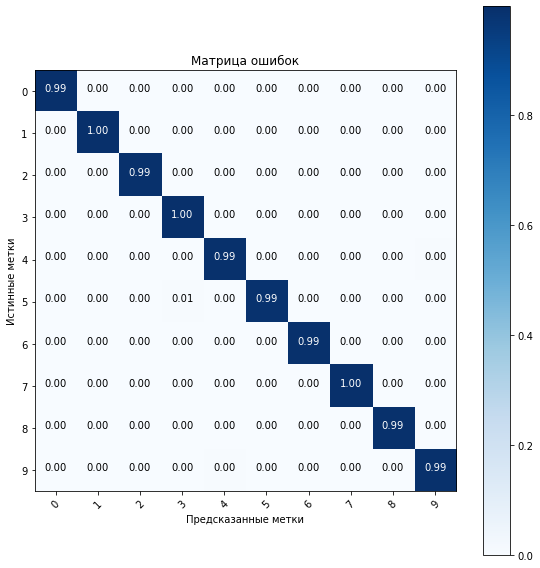

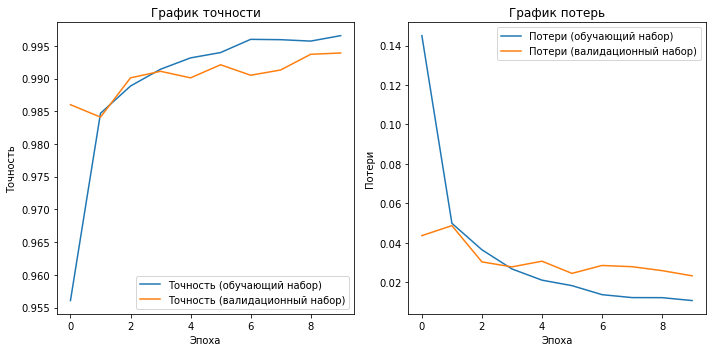

In [14]:
evaluate_and_visualize(model_CNN, test_images, test_labels, classes)

#### 4.3. Рекуррентная нейронная сеть (Recurrent Neural Network, RNN)
RNN подходят для последовательных данных, для MNIST они могут быть применены, например, к последовательности строк пикселей.

In [15]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)


Изображения изменяют форму, чтобы соответствовать требованиям входа в модель LSTM, где каждое изображение представляется как последовательность временных шагов (28 временных шагов по 28 признаков в каждом).

In [16]:
model_RNN = models.Sequential([
    layers.LSTM(128, input_shape=(28, 28)),
    layers.Dense(10)
])


Здесь создается модель с одним слоем LSTM, содержащим 128 блоков LSTM, и слоем Dense с 10 выходными нейронами, соответствующими 10 классам (цифры от 0 до 9).

In [17]:
model_RNN.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


Модель компилируется с оптимизатором Adam, функцией потерь Sparse Categorical Crossentropy (так как у нас целочисленные метки классов), и метрикой точности для отслеживания производительности модели в процессе обучения.

In [18]:
history = model_RNN.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))


Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3339 - accuracy: 0.8925 - val_loss: 0.1481 - val_accuracy: 0.9531
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1034 - accuracy: 0.9693 - val_loss: 0.0805 - val_accuracy: 0.9748
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0726 - accuracy: 0.9778 - val_loss: 0.0707 - val_accuracy: 0.9783
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0558 - accuracy: 0.9829 - val_loss: 0.0568 - val_accuracy: 0.9815
Epoch 5/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0457 - accuracy: 0.9858 - val_loss: 0.0555 - val_accuracy: 0.9832
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0368 - accuracy: 0.9885 - val_loss: 0.0475 - val_accuracy: 0.9861
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0325 - accuracy: 0.9899 - val_loss: 0.0487 -

In [19]:
test_loss, test_acc = model_RNN.evaluate(test_images, test_labels, verbose=2)
print(f'\nТочность на тестовом наборе данных: {test_acc}')


313/313 - 1s - loss: 0.0474 - accuracy: 0.9862 - 1s/epoch - 4ms/step

Точность на тестовом наборе данных: 0.9861999750137329


313/313 - 1s - loss: 0.0474 - accuracy: 0.9862 - 1s/epoch - 4ms/step

Точность на тестовом наборе данных: 0.9861999750137329
313/313 [==============================] - 2s 5ms/step

Матрица ошибок:
[[ 969    0    2    0    0    0    7    1    1    0]
 [   0 1130    1    0    0    0    1    1    1    1]
 [   0    1 1025    0    1    0    0    1    3    1]
 [   0    0    4  993    0    8    0    0    5    0]
 [   0    0    1    0  975    0    5    0    0    1]
 [   0    0    0    4    1  883    2    0    1    1]
 [   2    3    0    0    0    2  949    0    2    0]
 [   0    3    9    2    5    1    0  992    4   12]
 [   0    0    3    0   11    2    2    0  952    4]
 [   1    0    0    0   14    0    0    0    0  994]]

Наиболее часто путаемые символы:
Символ 9 (настоящий) <-> Символ 4 (предсказанный): 14 случаев
Символ 7 (настоящий) <-> Символ 9 (предсказанный): 12 случаев
Символ 8 (настоящий) <-> Символ 4 (предсказанный): 11 случаев
Символ 7 (настоящий) <-> Символ 2 (предсказанный): 9

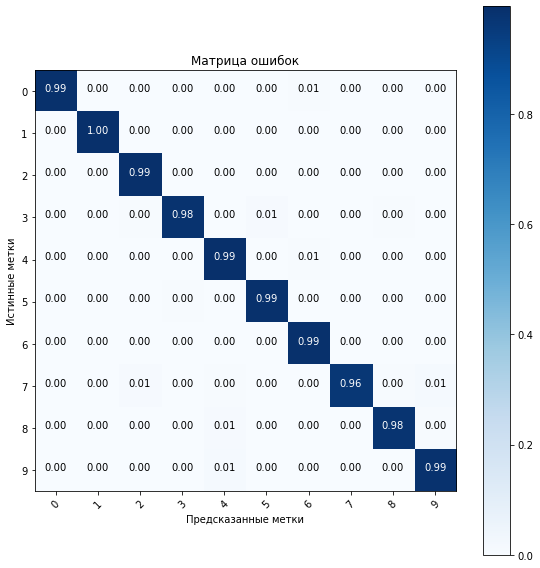

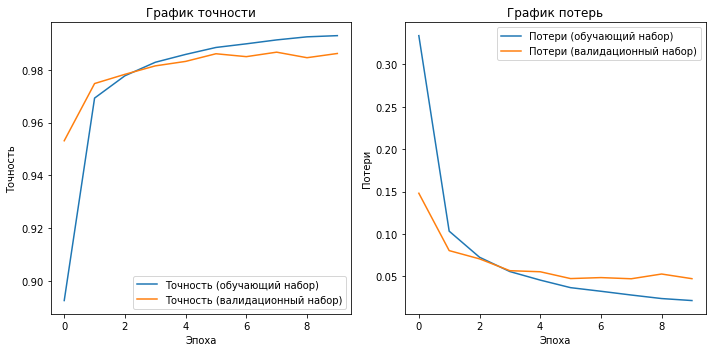

In [20]:
evaluate_and_visualize(model_RNN, test_images, test_labels, classes)

#### 4.4. Глубокая полносвязная нейронная сеть "DNN" (Deep Neural Network)

In [22]:
# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Преобразование изображений в плоский вектор
train_images = train_images.reshape(train_images.shape[0], 28*28)
test_images = test_images.reshape(test_images.shape[0], 28*28)

# Создание модели с улучшенной архитектурой
model_DNN = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(28*28,)),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10)
])

# Компиляция модели с настройкой оптимизатора и функции потерь
optimizer = optimizers.Adam(learning_rate=0.001)
model_DNN.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# Вывод структуры модели
model_DNN.summary()

# Настройка для early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Обучение модели с использованием валидационных данных
history = model_DNN.fit(train_images, train_labels, 
                        epochs=50, 
                        validation_data=(test_images, test_labels), 
                        callbacks=[early_stopping])

# Оценка точности на тестовом наборе данных
test_loss, test_acc = model_DNN.evaluate(test_images, test_labels, verbose=2)
print(f'\nТочность на тестовом наборе данных: {test_acc}')


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               401920    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 10)               

313/313 - 0s - loss: 0.1893 - accuracy: 0.9712 - 371ms/epoch - 1ms/step

Точность на тестовом наборе данных: 0.9711999893188477
313/313 [==============================] - 0s 1ms/step

Матрица ошибок:
[[ 970    0    1    0    0    0    3    0    5    1]
 [   0 1099    3    1    1    1    5    1   19    5]
 [   3    0 1007    3    2    0    3    3   11    0]
 [   0    0   12  964    0   18    0    2   11    3]
 [   3    0    0    0  958    0    6    1    0   14]
 [   4    0    0    3    0  852    9    0   17    7]
 [   4    2    0    0    1    2  945    0    4    0]
 [   1    1   15    2    1    0    0  992    3   13]
 [   2    0    5    1    3    2    3    2  954    2]
 [   2    2    1    3    6    2    0    2   20  971]]

Наиболее часто путаемые символы:
Символ 9 (настоящий) <-> Символ 8 (предсказанный): 20 случаев
Символ 1 (настоящий) <-> Символ 8 (предсказанный): 19 случаев
Символ 3 (настоящий) <-> Символ 5 (предсказанный): 18 случаев
Символ 5 (настоящий) <-> Символ 8 (предсказанный)

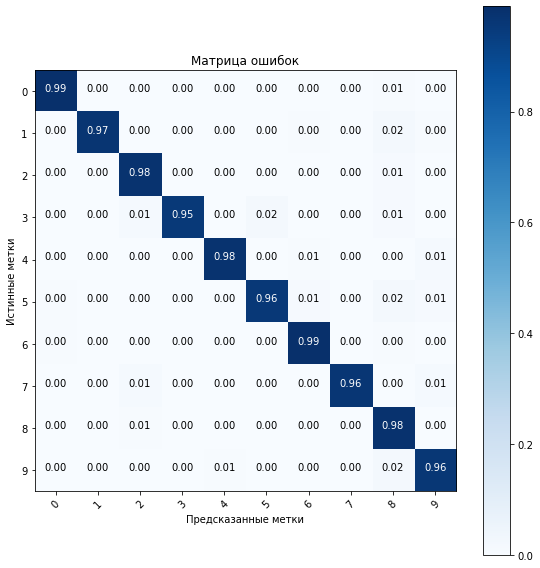

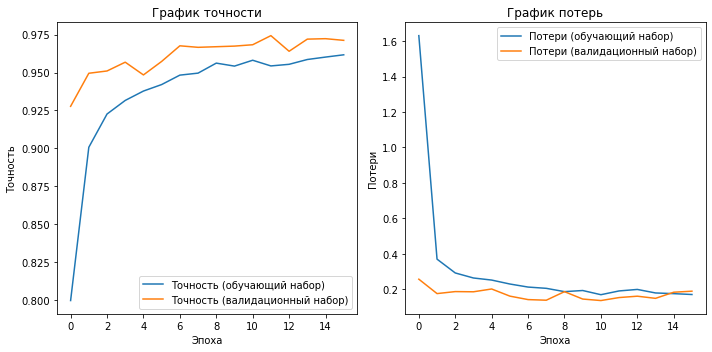

In [23]:
evaluate_and_visualize(model_DNN, test_images, test_labels, classes)

#### 4.5. Метод k-ближайших соседей (k-Nearest Neighbors, k-NN)

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()


# Преобразование изображений в плоский вектор
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Создание и обучение k-NN
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(train_images_flat, train_labels)

# Оценка точности
predictions = knn_model.predict(test_images_flat)
accuracy = accuracy_score(test_labels, predictions)
print(f"Точность k-NN на тестовом наборе данных: {accuracy}")


Точность k-NN на тестовом наборе данных: 0.9705


#### 4.6. Наивный байесовский классификатор (Naive Bayes Classifier)

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Преобразование изображений в плоский вектор
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Создание и обучение наивного байесовского классификатора
nb_model = GaussianNB()
nb_model.fit(train_images_flat, train_labels)

# Оценка точности
predictions = nb_model.predict(test_images_flat)
accuracy = accuracy_score(test_labels, predictions)
print(f"Точность наивного байесовского классификатора на тестовом наборе данных: {accuracy}")


Точность наивного байесовского классификатора на тестовом наборе данных: 0.5558


### Выводы

Сверточная нейронная сеть (Convolutional Neural Network, CNN) показала наилучшую производительность. Точность на тестовом наборе данных: 0.99

In [31]:

# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Нормализация и изменение формы данных
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Создание модели CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели на всем тренировочном наборе
model.fit(train_images, train_labels, epochs=, batch_size=64)

# Оценка точности на тестовом наборе данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'\nТочность на тестовом наборе данных: {test_acc}')

# Сохранение модели
model.save('mnist_cnn_model.h5')
print("Модель сохранена.")


Epoch 1/10
938/938 [==============================] - 8s 9ms/step - loss: 0.1596 - accuracy: 0.9536
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0462 - accuracy: 0.9856
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0327 - accuracy: 0.9897
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0254 - accuracy: 0.9920
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0179 - accuracy: 0.9944
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0155 - accuracy: 0.9949
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0114 - accuracy: 0.9964
Epoch 8/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0096 - accuracy: 0.9970
Epoch 9/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0089 - accuracy: 0.9970
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0424 - accuracy: 0.9899

1/1 [==============================] - 0s 121ms/step


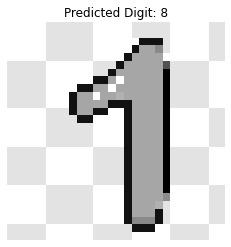

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))
    img = img.convert('L')  # Преобразование в оттенки серого
    img_array = np.array(img) / 255.0  # Нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    return img, img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_array = preprocess_image(image_path)
    
    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    # Вывод изображения и предсказанной цифры
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Predicted Digit: {predicted_class}')
    plt.show()

# Пример использования
image_path = '12.png'  # Укажите путь к вашему изображению с цифрой
predict_digit(image_path)


In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))
    img = img.convert('L')  # Преобразование в оттенки серого
    img_array = np.array(img) / 255.0  # Нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    return img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img_array = preprocess_image(image_path)
    
    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    return predicted_class

# Пример использования
image_path = 'images.png'  # Укажите путь к вашему изображению с цифрой
predicted_digit = predict_digit(image_path)
print(f'Predicted Digit: {predicted_digit}')


1/1 [==============================] - 0s 129ms/step
Predicted Digit: 8


In [70]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
from scipy.ndimage.measurements import center_of_mass
import math
import matplotlib.pyplot as plt

# Загрузка модели
model = load_model('mnist_cnn_model.h5')

def getBestShift(img):
    cy, cx = center_of_mass(img)
    rows, cols = img.shape
    shiftx = np.round(cols / 2.0 - cx).astype(int)
    shifty = np.round(rows / 2.0 - cy).astype(int)
    return shiftx, shifty

def shift(img, sx, sy):
    rows, cols = img.shape
    M = np.float32([[1, 0, sx], [0, 1, sy]])
    shifted = cv2.warpAffine(img, M, (cols, rows))
    return shifted

def rec_digit(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gray = 255 - img
    (thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    while np.sum(gray[0]) == 0:
        gray = gray[1:]
    while np.sum(gray[:, 0]) == 0:
        gray = np.delete(gray, 0, 1)
    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]
    while np.sum(gray[:, -1]) == 0:
        gray = np.delete(gray, -1, 1)
    
    rows, cols = gray.shape

    if rows > cols:
        factor = 20.0 / rows
        rows = 20
        cols = int(round(cols * factor))
        gray = cv2.resize(gray, (cols, rows))
    else:
        factor = 20.0 / cols
        cols = 20
        rows = int(round(rows * factor))
        gray = cv2.resize(gray, (cols, rows))

    colsPadding = (int(math.ceil((28 - cols) / 2.0)), int(math.floor((28 - cols) / 2.0)))
    rowsPadding = (int(math.ceil((28 - rows) / 2.0)), int(math.floor((28 - rows) / 2.0)))
    gray = np.lib.pad(gray, (rowsPadding, colsPadding), 'constant')

    shiftx, shifty = getBestShift(gray)
    shifted = shift(gray, shiftx, shifty)
    gray = shifted

    img = gray / 255.0
    img = np.array(img).reshape(-1, 28, 28, 1)
    out = str(np.argmax(model.predict(img)))
    return out

#

In [71]:
# Путь к изображению с цифрой
image_path = '8.jpg'  # Укажите путь к вашему изображению с цифрой

# Распознавание цифры
predicted_digit = rec_digit(image_path)
print(f'Predicted Digit: {predicted_digit}')

1/1 [==============================] - 0s 68ms/step
Predicted Digit: 2


In [56]:
!pip install cv2

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


In [62]:
for i in range(25):
    print(f"Размер изображения {i+1}: {train_images[i].shape}")


Размер изображения 1: (28, 28, 1)
Размер изображения 2: (28, 28, 1)
Размер изображения 3: (28, 28, 1)
Размер изображения 4: (28, 28, 1)
Размер изображения 5: (28, 28, 1)
Размер изображения 6: (28, 28, 1)
Размер изображения 7: (28, 28, 1)
Размер изображения 8: (28, 28, 1)
Размер изображения 9: (28, 28, 1)
Размер изображения 10: (28, 28, 1)
Размер изображения 11: (28, 28, 1)
Размер изображения 12: (28, 28, 1)
Размер изображения 13: (28, 28, 1)
Размер изображения 14: (28, 28, 1)
Размер изображения 15: (28, 28, 1)
Размер изображения 16: (28, 28, 1)
Размер изображения 17: (28, 28, 1)
Размер изображения 18: (28, 28, 1)
Размер изображения 19: (28, 28, 1)
Размер изображения 20: (28, 28, 1)
Размер изображения 21: (28, 28, 1)
Размер изображения 22: (28, 28, 1)
Размер изображения 23: (28, 28, 1)
Размер изображения 24: (28, 28, 1)
Размер изображения 25: (28, 28, 1)


### Приложение Streamlit

In [64]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Загрузка предобученной модели
model = tf.keras.models.load_model('mnist_cnn_model.h5')

# Функция для предобработки загруженного изображения
def preprocess_image(image):
    img = Image.open(image)
    img = img.convert('L')  # Преобразование в grayscale
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img_array = np.array(img) / 255.0  # Преобразование в массив и нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Изменение формы для модели CNN
    return img, img_array

# Виджет для загрузки изображения
uploader = widgets.FileUpload()
display(uploader)

# Обработка загруженного изображения
def on_upload(change):
    uploaded_image = list(uploader.value.values())[0]
    user_image, img_array = preprocess_image(uploaded_image)

    # Отображение предобработанных изображений
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

    # Скрытие меток осей для всех подграфиков
    for axis in ax.flat:
        axis.set_xticks([])
        axis.set_yticks([])

    # Исходное изображение
    ax[0, 0].set_title("Original Image")
    ax[0, 0].imshow(user_image, cmap='gray')

    # Измененное изображение (28 * 28)
    resized_image = user_image.resize((28, 28))
    ax[0, 1].set_title("Resized Image")
    ax[0, 1].imshow(resized_image, cmap='gray')

    # Grayscale изображение
    grayscaled_image = resized_image.convert("L")
    ax[0, 2].set_title("Grayscale Image")
    ax[0, 2].imshow(grayscaled_image, cmap="gray")

    # Инвертированное изображение (текст белый, фон черный)
    inverted_image = 255 - np.array(grayscaled_image)
    ax[1, 0].set_title("Inverted Image")
    ax[1, 0].imshow(inverted_image, cmap="gray")

    # Нормализованное изображение (делим на 255, чтобы значения были от 0 до 1)
    normalized_image = inverted_image / 255.0
    ax[1, 1].set_title("Normalized Image")
    ax[1, 1].imshow(normalized_image, cmap="gray")

    # Измененная форма изображения
    reshaped_image = normalized_image.reshape((28, 28))
    ax[1, 2].set_title("Reshaped Image")
    ax[1, 2].imshow(reshaped_image, cmap="gray")

    plt.tight_layout()
    plt.show()

    # Предсказание с использованием предобученной модели
    result = model.predict(img_array)
    predicted_class = np.argmax(result)

    print(f'Предсказанная цифра: {predicted_class}')

uploader.observe(on_upload, names='value')


FileUpload(value={}, description='Upload')

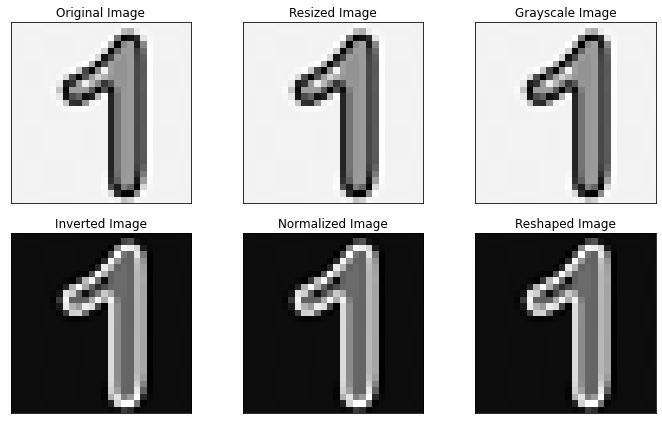

1/1 [==============================] - 0s 74ms/step
Предсказанная цифра: 4


In [120]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка предобученной модели
model = tf.keras.models.load_model('mnist_cnn_model.h5')

# Функция для предобработки изображения по пути к файлу
def preprocess_image_from_path(image_path):
    img = Image.open(image_path)
    img = img.convert('L')  # Преобразование в grayscale
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img_array = np.array(img) / 255.0  # Преобразование в массив и нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Изменение формы для модели CNN
    return img, img_array

# Путь к изображению
image_path = '12.png'  # Замените на актуальный путь к вашему изображению

try:
    # Предобработка изображения
    user_image, img_array = preprocess_image_from_path(image_path)

    # Отображение предобработанных изображений с помощью Matplotlib
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

    # Скрытие меток осей для всех подграфиков
    for axis in ax.flat:
        axis.set_xticks([])
        axis.set_yticks([])

    # Исходное изображение
    ax[0, 0].set_title("Original Image")
    ax[0, 0].imshow(user_image, cmap='gray')

    # Измененное изображение (28 * 28)
    resized_image = user_image.resize((28, 28))
    ax[0, 1].set_title("Resized Image")
    ax[0, 1].imshow(resized_image, cmap='gray')

    # Grayscale изображение
    grayscaled_image = resized_image.convert("L")
    ax[0, 2].set_title("Grayscale Image")
    ax[0, 2].imshow(grayscaled_image, cmap="gray")

    # Инвертированное изображение (текст белый, фон черный)
    inverted_image = 255 - np.array(grayscaled_image)
    ax[1, 0].set_title("Inverted Image")
    ax[1, 0].imshow(inverted_image, cmap="gray")

    # Нормализованное изображение (делим на 255, чтобы значения были от 0 до 1)
    normalized_image = inverted_image / 255.0
    ax[1, 1].set_title("Normalized Image")
    ax[1, 1].imshow(normalized_image, cmap="gray")

    # Измененная форма изображения
    reshaped_image = normalized_image.reshape((28, 28))
    ax[1, 2].set_title("Reshaped Image")
    ax[1, 2].imshow(reshaped_image, cmap="gray")

    plt.tight_layout()
    plt.show()

    # Предсказание с использованием предобученной модели
    result = model.predict(img_array)
    predicted_class = np.argmax(result)

    print(f'Предсказанная цифра: {predicted_class}')

except Exception as e:
    print(f'Ошибка: {e}')


1/1 [==============================] - 0s 121ms/step
Predicted Digit: 8


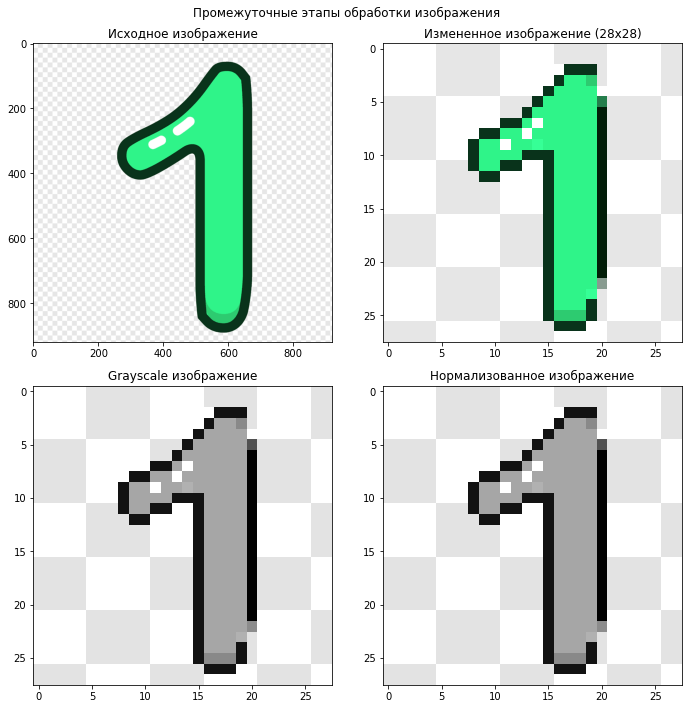

In [115]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img.save("original_image.png")
    
    img = img.resize((28, 28))
    img.save("resized_image.png")
    
    img = img.convert('L')  # Преобразование в оттенки серого
    img.save("grayscale_image.png")
    
    img_array = np.array(img) / 255.0  # Нормализация
    normalized_image = Image.fromarray((img_array * 255).astype(np.uint8))
    normalized_image.save("normalized_image.png")
    
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    return img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img_array = preprocess_image(image_path)
    
    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    return predicted_class

# Пример использования
image_path = '12.png'  # Укажите путь к вашему изображению с цифрой
predicted_digit = predict_digit(image_path)
print(f'Predicted Digit: {predicted_digit}')

# Отображение всех этапов обработки изображения
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle("Промежуточные этапы обработки изображения")

original_image = Image.open("original_image.png")
resized_image = Image.open("resized_image.png")
grayscale_image = Image.open("grayscale_image.png")
normalized_image = Image.open("normalized_image.png")

ax[0, 0].set_title("Исходное изображение")
ax[0, 0].imshow(original_image)

ax[0, 1].set_title("Измененное изображение (28x28)")
ax[0, 1].imshow(resized_image)

ax[1, 0].set_title("Grayscale изображение")
ax[1, 0].imshow(grayscale_image, cmap='gray')

ax[1, 1].set_title("Нормализованное изображение")
ax[1, 1].imshow(normalized_image, cmap='gray')

plt.tight_layout()
plt.show()


In [113]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого
    
    # Инвертирование изображения
    img = ImageOps.invert(img)
    
    img_array = np.array(img) / 255.0  # Нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    return img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img_array = preprocess_image(image_path)
    
    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    return predicted_class

# Пример использования
image_path = '888.png'  # Укажите путь к вашему изображению с цифрой
predicted_digit = predict_digit(image_path)
print(f'Предсказанная цифра: {predicted_digit}')


1/1 [==============================] - 0s 116ms/step
Предсказанная цифра: 1


1/1 [==============================] - 0s 119ms/step


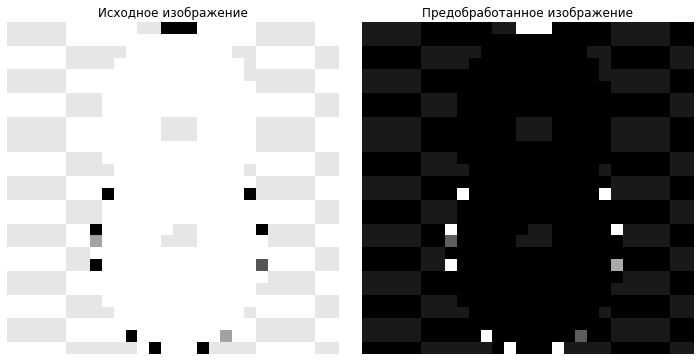

Предсказанная цифра: 1


In [112]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого
    
    # Инвертирование изображения
    img_inverted = ImageOps.invert(img)
    
    img_array = np.array(img_inverted) / 255.0  # Нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    
    return img, img_inverted, img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_inverted, img_array = preprocess_image(image_path)
    
    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    return img, img_inverted, predicted_class

# Пример использования
image_path = '888.png'  # Укажите путь к вашему изображению с цифрой
img, img_inverted, predicted_digit = predict_digit(image_path)

# Показ исходного и предобработанного изображений
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(img_inverted, cmap='gray')
axes[1].set_title('Предобработанное изображение')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f'Предсказанная цифра: {predicted_digit}')


1/1 [==============================] - 0s 115ms/step


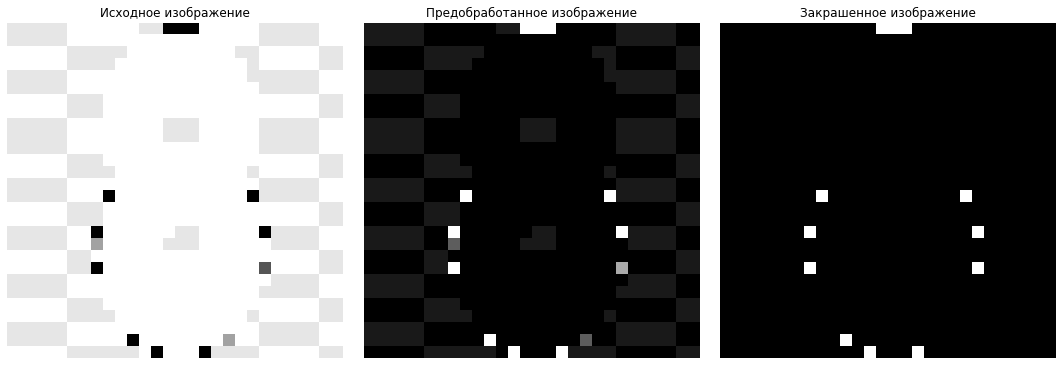

Предсказанная цифра: 1


In [111]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого
    
    # Инвертирование изображения
    img_inverted = ImageOps.invert(img)
    
    img_array = np.array(img_inverted) / 255.0  # Нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    
    return img, img_inverted, img_array

# Функция для закрашивания контура цифры
def fill_digit_contour(img):
    # Преобразование изображения в массив
    img_array = np.array(img)
    
    # Бинаризация изображения
    _, binary_image = cv2.threshold(img_array, 128, 255, cv2.THRESH_BINARY)
    
    # Поиск контуров
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Закрашивание контуров
    cv2.drawContours(binary_image, contours, -1, (255), thickness=cv2.FILLED)
    
    return Image.fromarray(binary_image)

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_inverted, img_array = preprocess_image(image_path)
    
    # Закрашивание контура цифры
    img_filled = fill_digit_contour(img_inverted)
    
    # Предсказание класса с использованием модели
    img_filled_array = np.array(img_filled) / 255.0
    img_filled_array = img_filled_array.reshape((1, 28, 28, 1))
    prediction = model.predict(img_filled_array)
    predicted_class = np.argmax(prediction)
    
    return img, img_inverted, img_filled, predicted_class

# Пример использования
image_path = '888.png'  # Укажите путь к вашему изображению с цифрой
img, img_inverted, img_filled, predicted_digit = predict_digit(image_path)

# Показ исходного и предобработанного изображений
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(img_inverted, cmap='gray')
axes[1].set_title('Предобработанное изображение')
axes[1].axis('off')

axes[2].imshow(img_filled, cmap='gray')
axes[2].set_title('Закрашенное изображение')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f'Предсказанная цифра: {predicted_digit}')


1/1 [==============================] - 0s 118ms/step


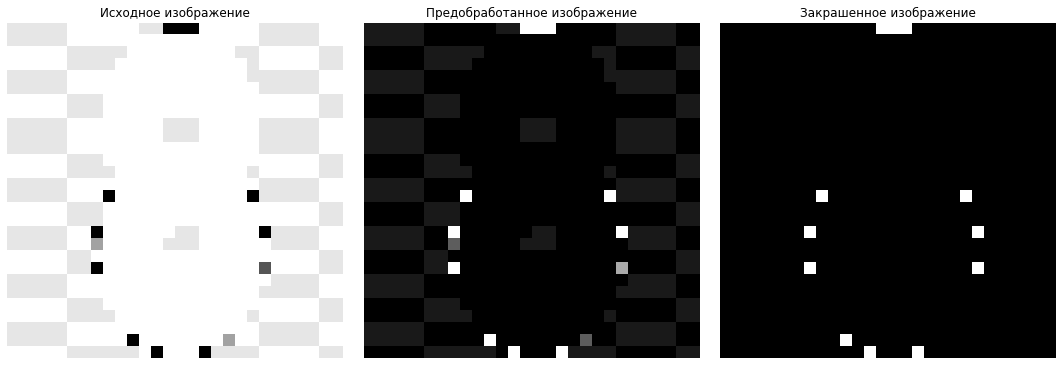

Предсказанная цифра: 1


In [110]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого
    
    # Инвертирование изображения
    img_inverted = ImageOps.invert(img)
    
    img_array = np.array(img_inverted) / 255.0  # Нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    
    return img, img_inverted, img_array

# Функция для закрашивания контура цифры
def fill_digit_contour(img):
    # Преобразование изображения в массив
    img_array = np.array(img)
    
    # Бинаризация изображения
    _, binary_image = cv2.threshold(img_array, 128, 255, cv2.THRESH_BINARY)
    
    # Поиск контуров
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Закрашивание контуров белым цветом
    cv2.drawContours(binary_image, contours, -1, (255), thickness=cv2.FILLED)
    
    return Image.fromarray(binary_image)

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_inverted, img_array = preprocess_image(image_path)
    
    # Закрашивание контура цифры
    img_filled = fill_digit_contour(img_inverted)
    
    # Предсказание класса с использованием модели
    img_filled_array = np.array(img_filled) / 255.0
    img_filled_array = img_filled_array.reshape((1, 28, 28, 1))
    prediction = model.predict(img_filled_array)
    predicted_class = np.argmax(prediction)
    
    return img, img_inverted, img_filled, predicted_class

# Пример использования
image_path = '888.png'  # Укажите путь к вашему изображению с цифрой
img, img_inverted, img_filled, predicted_digit = predict_digit(image_path)

# Показ исходного и предобработанного изображений
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(img_inverted, cmap='gray')
axes[1].set_title('Предобработанное изображение')
axes[1].axis('off')

axes[2].imshow(img_filled, cmap='gray')
axes[2].set_title('Закрашенное изображение')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f'Предсказанная цифра: {predicted_digit}')


1/1 [==============================] - 0s 121ms/step


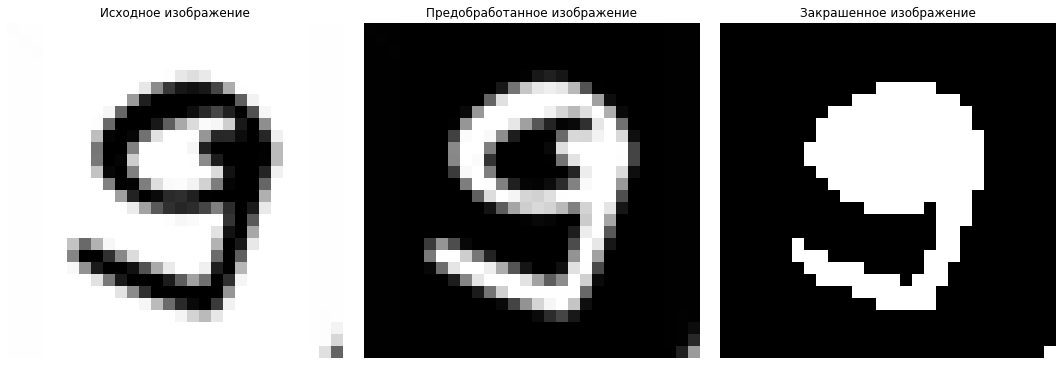

Предсказанная цифра: 9


In [107]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого
    
    # Инвертирование изображения
    img_inverted = ImageOps.invert(img)
    
    img_array = np.array(img_inverted) / 255.0  # Нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    return img, img_inverted, img_array

# Функция для закрашивания контура цифры
def fill_digit_contour(img):
    # Преобразование изображения в массив
    img_array = np.array(img)
    
    # Бинаризация изображения
    _, binary_image = cv2.threshold(img_array, 128, 255, cv2.THRESH_BINARY)
    
    # Поиск контуров
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Закрашивание контуров
    for contour in contours:
        cv2.drawContours(binary_image, [contour], -1, (255), thickness=cv2.FILLED)
    
    return Image.fromarray(binary_image)

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_inverted, img_array = preprocess_image(image_path)
    
    # Закрашивание контура цифры
    img_filled = fill_digit_contour(img_inverted)
    
    # Предсказание класса с использованием модели
    img_filled_array = np.array(img_filled) / 255.0
    img_filled_array = img_filled_array.reshape((1, 28, 28, 1))
    prediction = model.predict(img_filled_array)
    predicted_class = np.argmax(prediction)
    
    return img, img_inverted, img_filled, predicted_class

# Пример использования
image_path = '9.png'  # Укажите путь к вашему изображению с цифрой
img, img_inverted, img_filled, predicted_digit = predict_digit(image_path)

# Показ исходного и предобработанного изображений
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(img_inverted, cmap='gray')
axes[1].set_title('Предобработанное изображение')
axes[1].axis('off')

axes[2].imshow(img_filled, cmap='gray')
axes[2].set_title('Закрашенное изображение')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f'Предсказанная цифра: {predicted_digit}')


1/1 [==============================] - 0s 122ms/step


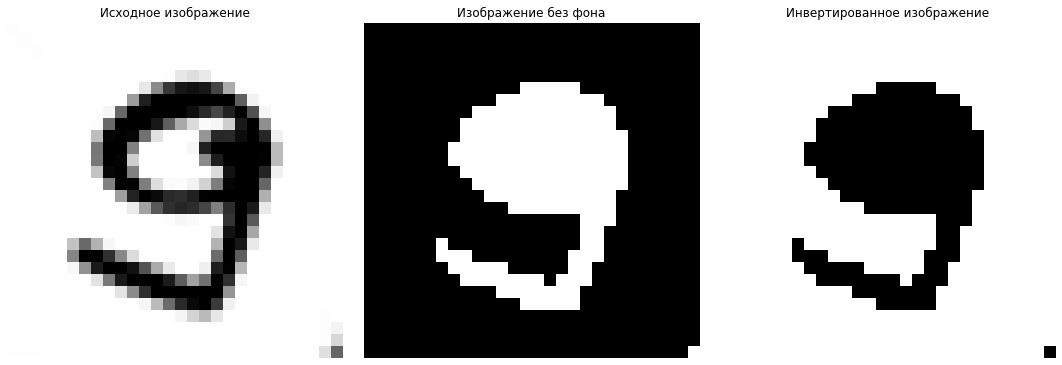

Предсказанная цифра: 0


In [106]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого
    
    # Удаление фона
    img_np = np.array(img)
    _, binary_img = cv2.threshold(img_np, 128, 255, cv2.THRESH_BINARY_INV)
    
    # Поиск контуров и закрашивание внутри контура
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(binary_img, contours, -1, (255), thickness=cv2.FILLED)
    
    img_filled = Image.fromarray(binary_img)
    
    # Инвертирование изображения
    img_inverted = ImageOps.invert(img_filled)
    
    img_array = np.array(img_inverted) / 255.0  # Нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    return img, img_inverted, img_filled, img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_inverted, img_filled, img_array = preprocess_image(image_path)
    
    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    return img, img_inverted, img_filled, predicted_class

# Пример использования
image_path = '9.png'  # Укажите путь к вашему изображению с цифрой
img, img_inverted, img_filled, predicted_digit = predict_digit(image_path)

# Показ исходного и предобработанного изображений
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(img_filled, cmap='gray')
axes[1].set_title('Изображение без фона')
axes[1].axis('off')

axes[2].imshow(img_inverted, cmap='gray')
axes[2].set_title('Инвертированное изображение')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f'Предсказанная цифра: {predicted_digit}')


1/1 [==============================] - 0s 115ms/step


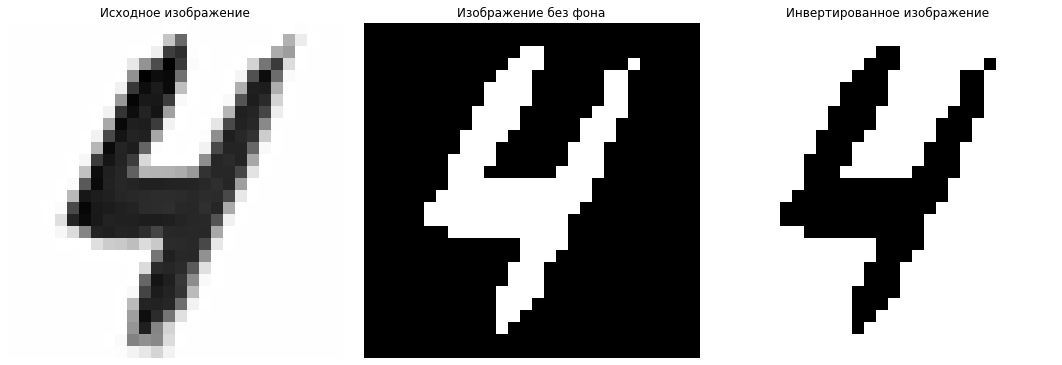

Предсказанная цифра: 2


In [134]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого
    
    # Удаление фона
    img_np = np.array(img)
    _, binary_img = cv2.threshold(img_np, 128, 255, cv2.THRESH_BINARY_INV)
    
    # Поиск контуров
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Создание маски для заливки контуров
    mask = np.zeros_like(binary_img)
    
    # Закрашивание контуров
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Применение маски к исходному изображению
    img_filled = cv2.bitwise_and(binary_img, mask)
    
    img_filled_pil = Image.fromarray(img_filled)
    
    # Инвертирование изображения
    img_inverted = ImageOps.invert(img_filled_pil)
    
    img_array = np.array(img_inverted) / 255.0  # Нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    return img, img_inverted, img_filled_pil, img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_inverted, img_filled, img_array = preprocess_image(image_path)
    
    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    return img, img_inverted, img_filled, predicted_class

# Пример использования
image_path = '4.png'  # Укажите путь к вашему изображению с цифрой
img, img_inverted, img_filled, predicted_digit = predict_digit(image_path)

# Показ исходного и предобработанного изображений
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(img_filled, cmap='gray')
axes[1].set_title('Изображение без фона')
axes[1].axis('off')

axes[2].imshow(img_inverted, cmap='gray')
axes[2].set_title('Инвертированное изображение')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f'Предсказанная цифра: {predicted_digit}')


1/1 [==============================] - 0s 118ms/step


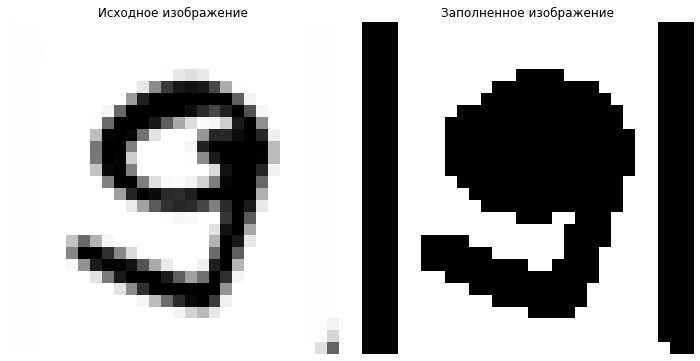

Предсказанная цифра: 0


In [104]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого

    # Преобразование изображения в numpy массив
    img_np = np.array(img)

    # Инвертирование изображения
    img_inverted_np = cv2.bitwise_not(img_np)

    # Поиск контуров
    contours, _ = cv2.findContours(img_inverted_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Заполнение внутренней части цифры
    cv2.drawContours(img_inverted_np, contours, -1, (255), thickness=cv2.FILLED)

    # Инвертирование обратно
    img_filled_np = cv2.bitwise_not(img_inverted_np)

    img_filled_pil = Image.fromarray(img_filled_np)

    # Нормализация изображения
    img_array = np.array(img_filled_pil) / 255.0
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала

    return img, img_filled_pil, img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_filled, img_array = preprocess_image(image_path)

    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    return img, img_filled, predicted_class

# Пример использования
image_path = '9.png'  # Укажите путь к вашему изображению с цифрой
img, img_filled, predicted_digit = predict_digit(image_path)

# Показ исходного и предобработанного изображений
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(img_filled, cmap='gray')
axes[1].set_title('Заполненное изображение')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f'Предсказанная цифра: {predicted_digit}')


1/1 [==============================] - 0s 121ms/step


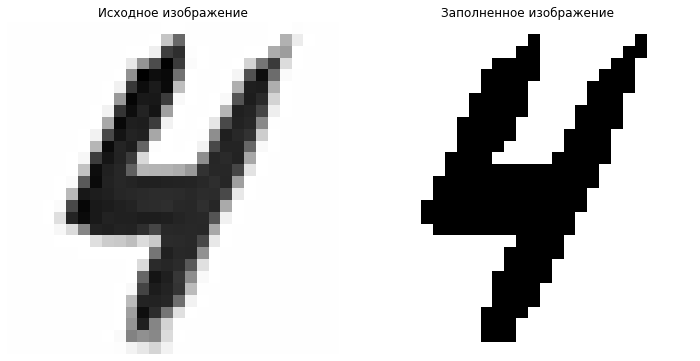

Предсказанная цифра: 2


In [130]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого

    # Преобразование изображения в numpy массив
    img_np = np.array(img)

    # Удаление фона (все, что близко к белому, станет фоном)
    _, img_no_bg = cv2.threshold(img_np, 200, 255, cv2.THRESH_BINARY)

    # Инвертирование изображения
    img_inverted_np = cv2.bitwise_not(img_no_bg)

    # Поиск контуров
    contours, _ = cv2.findContours(img_inverted_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Заполнение внутренней части цифры
    cv2.drawContours(img_inverted_np, contours, -1, (255), thickness=cv2.FILLED)

    # Инвертирование обратно
    img_filled_np = cv2.bitwise_not(img_inverted_np)

    img_filled_pil = Image.fromarray(img_filled_np)

    # Нормализация изображения
    img_array = np.array(img_filled_pil) / 255.0
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала

    return img, img_filled_pil, img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_filled, img_array = preprocess_image(image_path)

    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    return img, img_filled, predicted_class

# Пример использования
image_path = '4.png'  # Укажите путь к вашему изображению с цифрой
img, img_filled, predicted_digit = predict_digit(image_path)

# Показ исходного и предобработанного изображений
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(img_filled, cmap='gray')
axes[1].set_title('Заполненное изображение')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f'Предсказанная цифра: {predicted_digit}')


1/1 [==============================] - 0s 132ms/step


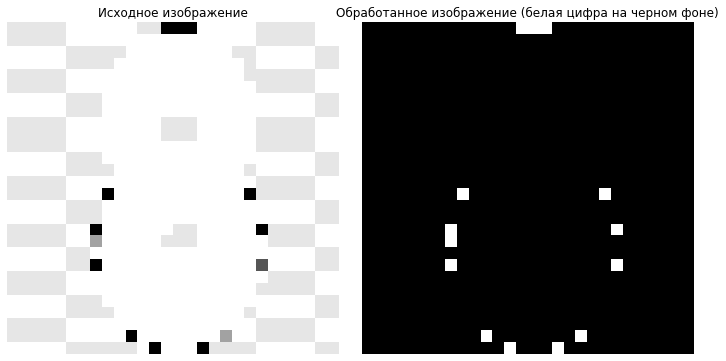

Предсказанная цифра: 1


In [99]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого

    # Преобразование изображения в numpy массив
    img_np = np.array(img)

    # Удаление фона (все, что близко к белому, станет фоном)
    _, img_no_bg = cv2.threshold(img_np, 200, 255, cv2.THRESH_BINARY)

    # Инвертирование изображения
    img_inverted_np = cv2.bitwise_not(img_no_bg)

    # Поиск контуров
    contours, _ = cv2.findContours(img_inverted_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Заполнение внутренней части цифры
    cv2.drawContours(img_inverted_np, contours, -1, (255), thickness=cv2.FILLED)

    # Инвертирование обратно
    img_filled_np = cv2.bitwise_not(img_inverted_np)

    # Создание конечного изображения (цифра белая на черном фоне)
    img_final_np = cv2.bitwise_not(img_filled_np)
    img_final_pil = Image.fromarray(img_final_np)

    # Нормализация изображения
    img_array = np.array(img_final_pil) / 255.0
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала

    return img, img_final_pil, img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_final, img_array = preprocess_image(image_path)

    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    return img, img_final, predicted_class

# Пример использования
image_path = '888.png'  # Укажите путь к вашему изображению с цифрой
img, img_final, predicted_digit = predict_digit(image_path)

# Показ исходного и предобработанного изображений
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(img_final, cmap='gray')
axes[1].set_title('Обработанное изображение (белая цифра на черном фоне)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f'Предсказанная цифра: {predicted_digit}')


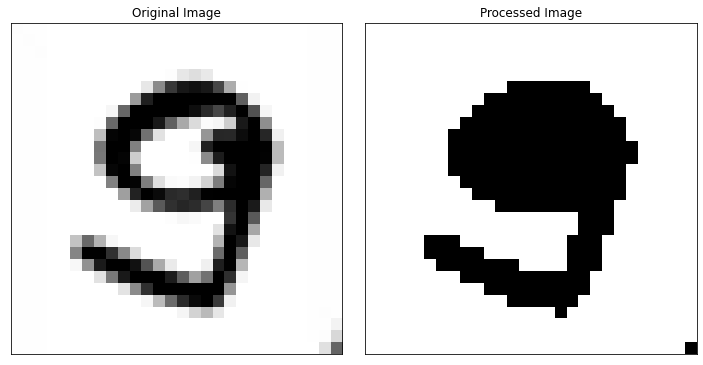

1/1 [==============================] - 0s 67ms/step
Предсказанная цифра: 6


In [125]:
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Загрузка предобученной модели
model = tf.keras.models.load_model('mnist_cnn_model.h5')

# Функция для предобработки изображения по пути к файлу
def preprocess_image_from_path(image_path):
    img = Image.open(image_path)
    img = img.convert('L')  # Преобразование в grayscale
    img = img.resize((28, 28))  # Изменение размера до 28x28
    
    # Преобразование изображения в numpy массив
    img_np = np.array(img)
    
    # Удаление фона (все, что близко к белому, станет фоном)
    _, img_no_bg = cv2.threshold(img_np, 200, 255, cv2.THRESH_BINARY)

    # Инвертирование изображения
    img_inverted_np = cv2.bitwise_not(img_no_bg)

    # Поиск контуров
    contours, _ = cv2.findContours(img_inverted_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Создание маски
    mask = np.zeros_like(img_inverted_np)

    # Заполнение внутренней части цифры
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    # Инвертирование обратно
    img_filled_np = cv2.bitwise_not(mask)

    # Нормализация изображения
    img_array = img_filled_np / 255.0
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала

    return img, img_filled_np, img_array

# Путь к изображению
image_path = '9.png'  # Замените на актуальный путь к вашему изображению

try:
    # Предобработка изображения
    user_image, processed_image, img_array = preprocess_image_from_path(image_path)

    # Отображение предобработанных изображений с помощью Matplotlib
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Скрытие меток осей для всех подграфиков
    for axis in ax.flat:
        axis.set_xticks([])
        axis.set_yticks([])

    # Исходное изображение
    ax[0].set_title("Original Image")
    ax[0].imshow(user_image, cmap='gray')

    # Обработанное изображение (цифра белая на черном фоне)
    ax[1].set_title("Processed Image")
    ax[1].imshow(processed_image, cmap='gray')

    plt.tight_layout()
    plt.show()

    # Предсказание с использованием предобученной модели
    result = model.predict(img_array)
    predicted_class = np.argmax(result)

    print(f'Предсказанная цифра: {predicted_class}')

except Exception as e:
    print(f'Ошибка: {e}')


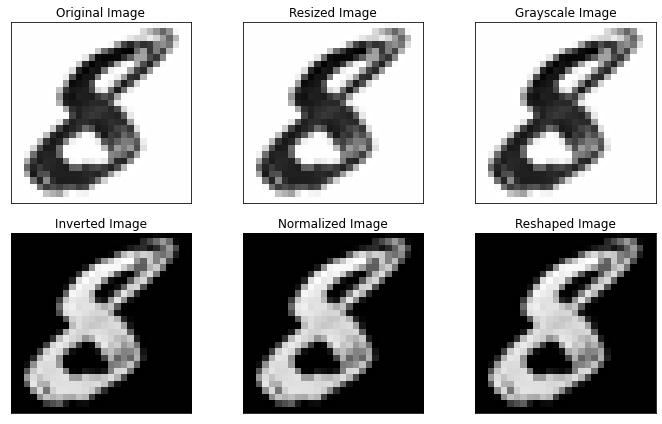

1/1 [==============================] - 0s 107ms/step
Предсказанная цифра: 8


In [142]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка предобученной модели
model = tf.keras.models.load_model('mnist_cnn_model.h5')

# Функция для предобработки изображения по пути к файлу
def preprocess_image_from_path(image_path):
    img = Image.open(image_path)
    img = img.convert('L')  # Преобразование в grayscale
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img_array = np.array(img) / 255.0  # Преобразование в массив и нормализация
    img_array = img_array.reshape((1, 28, 28, 1))  # Изменение формы для модели CNN
    return img, img_array

# Путь к изображению
image_path = '88.jpg'  # Замените на актуальный путь к вашему изображению

try:
    # Предобработка изображения
    user_image, img_array = preprocess_image_from_path(image_path)

    # Отображение предобработанных изображений с помощью Matplotlib
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

    # Скрытие меток осей для всех подграфиков
    for axis in ax.flat:
        axis.set_xticks([])
        axis.set_yticks([])

    # Исходное изображение
    ax[0, 0].set_title("Original Image")
    ax[0, 0].imshow(user_image, cmap='gray')

    # Измененное изображение (28 * 28)
    resized_image = user_image.resize((28, 28))
    ax[0, 1].set_title("Resized Image")
    ax[0, 1].imshow(resized_image, cmap='gray')

    # Grayscale изображение
    grayscaled_image = resized_image.convert("L")
    ax[0, 2].set_title("Grayscale Image")
    ax[0, 2].imshow(grayscaled_image, cmap="gray")

    # Инвертированное изображение (текст белый, фон черный)
    inverted_image = 255 - np.array(grayscaled_image)
    ax[1, 0].set_title("Inverted Image")
    ax[1, 0].imshow(inverted_image, cmap="gray")

    # Нормализованное изображение (делим на 255, чтобы значения были от 0 до 1)
    normalized_image = inverted_image / 255.0
    ax[1, 1].set_title("Normalized Image")
    ax[1, 1].imshow(normalized_image, cmap="gray")

    # Измененная форма изображения
    reshaped_image = normalized_image.reshape((28, 28))
    ax[1, 2].set_title("Reshaped Image")
    ax[1, 2].imshow(reshaped_image, cmap="gray")

    plt.tight_layout()
    plt.show()

    # Предсказание с использованием предобученной модели
    result = model.predict(img_array)
    predicted_class = np.argmax(result)

    print(f'Предсказанная цифра: {predicted_class}')

except Exception as e:
    print(f'Ошибка: {e}')


1/1 [==============================] - 0s 120ms/step


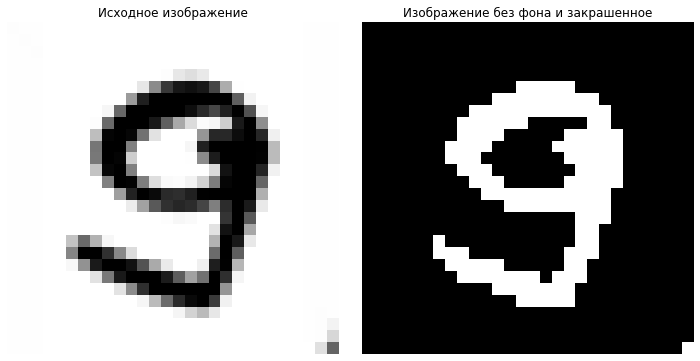

Предсказанная цифра: 9


In [138]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого
    
    # Удаление фона
    img_np = np.array(img)
    _, binary_img = cv2.threshold(img_np, 128, 255, cv2.THRESH_BINARY_INV)
    
    # Поиск контуров
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Создание маски для заливки контуров
    mask = np.zeros_like(binary_img)
    
    # Закрашивание контуров
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Применение маски к исходному изображению
    img_filled = cv2.bitwise_and(binary_img, mask)
    
    img_filled_pil = Image.fromarray(img_filled)
    
    # Нормализация изображения
    img_array = np.array(img_filled_pil) / 255.0
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    return img, img_filled_pil, img_array

# Функция для загрузки и предсказания
def predict_digit(image_path):
    img, img_filled, img_array = preprocess_image(image_path)
    
    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    return img, img_filled, predicted_class

# Пример использования
image_path = '9.png'  # Укажите путь к вашему изображению с цифрой
img, img_filled, predicted_digit = predict_digit(image_path)

# Показ исходного и предобработанного изображений
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(img_filled, cmap='gray')
axes[1].set_title('Изображение без фона и закрашенное')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f'Предсказанная цифра: {predicted_digit}')


In [141]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2
import streamlit as st

# Загрузка модели
model = load_model('mnist_cnn_mod.h5')

# Функция для предобработки изображения
def preprocess_image(img):
    img = img.resize((28, 28))  # Изменение размера до 28x28
    img = img.convert('L')  # Преобразование в оттенки серого
    
    # Удаление фона
    img_np = np.array(img)
    _, binary_img = cv2.threshold(img_np, 128, 255, cv2.THRESH_BINARY_INV)
    
    # Поиск контуров
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Создание маски для заливки контуров
    mask = np.zeros_like(binary_img)
    
    # Закрашивание контуров
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Применение маски к исходному изображению
    img_filled = cv2.bitwise_and(binary_img, mask)
    
    img_filled_pil = Image.fromarray(img_filled)
    
    # Нормализация изображения
    img_array = np.array(img_filled_pil) / 255.0
    img_array = img_array.reshape((1, 28, 28, 1))  # Добавление размерности канала
    return img, img_filled_pil, img_array

# Функция для загрузки и предсказания
def predict_digit(img):
    img, img_filled, img_array = preprocess_image(img)
    
    # Предсказание класса с использованием модели
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    return img, img_filled, predicted_class

# Streamlit приложение
st.title('Рисование цифр и предсказание')
st.write('Нарисуйте цифру внизу, затем нажмите кнопку "Предсказать".')

# Виджет для рисования
canvas_result = st.canvas(
    fill_color="white",
    stroke_width=10,
    stroke_color="black",
    background_color="white",
    width=280,
    height=280,
    drawing_mode="freedraw",
    key="canvas",
)

if canvas_result.image_data is not None:
    img = Image.fromarray((canvas_result.image_data * 255).astype(np.uint8))
    img = img.convert('L')  # Преобразование в оттенки серого
    
    if st.button('Предсказать'):
        img, img_filled, predicted_digit = predict_digit(img)
        
        # Показ исходного и предобработанного изображений
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Исходное изображение')
        axes[0].axis('off')

        axes[1].imshow(img_filled, cmap='gray')
        axes[1].set_title('Изображение без фона и закрашенное')
        axes[1].axis('off')

        st.pyplot(fig)
        st.write(f'Предсказанная цифра: {predicted_digit}')


ModuleNotFoundError: No module named 'streamlit'

In [140]:
!pip install streamlit


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\HP Z2\\AppData\\Local\\Temp\\pip-uninstall-d61n2ms1\\pygmentize.exe'
Consider using the `--user` option or check the permissions.



  Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
  Using cached altair-5.3.0-py3-none-any.whl (857 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl (6.9 MB)
  Using cached rich-13.7.1-py3-none-any.whl (240 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
  Using cached smmap-5.0.1-py3-none-any.whl (24 kB)
  Using cached pygments-2.18.0-py3-none-any.whl (1.2 MB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.10.0
    Uninstalling Pygments-2.10.0:
      Successfully uninstalled Pygments-2.10.0
